# SLT-CE-3: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf, chapter 2.7

# Important: everything is already runned, maybe the output is "clipped in" 
can change the view of output by: --> Cell/All Output/Toggle Scrolling
But it should be okay as it is handed in. 

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sn
import pandas as pd

from sklearn.utils.validation import check_is_fitted
from sklearn import feature_extraction
from matplotlib.image import imread
from scipy.optimize import linear_sum_assignment as l_s_a
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

## Texture and corresponding label map
(This texture is used to fit your model.)

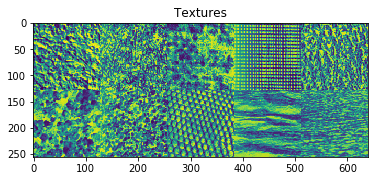

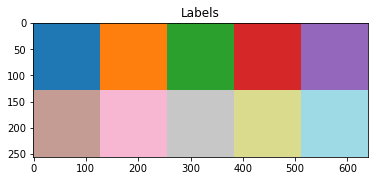

In [2]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

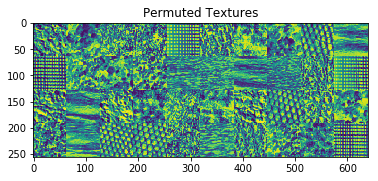

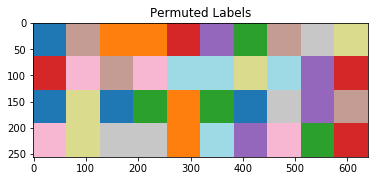

In [3]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.
</p>

Keeping the notation of reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a>, I first consider the MAP and afterwards DA.


**MAP**:
Following the equations 5 and 6 in the provided reference, the features given the class $y|c$ are empirically distributed as $\hat{P}(y|c) = \sum_{x:\hat{c}(x) = x} \hat{P}(x) \hat{P}(y|x)$ where $\hat{P}(x)  = \frac{n(x)}{\sum_{x' \in X} n(x')}$ and $\hat{P}(y|x) = \frac{n(x,y)}{n(x)}$. Further the object $x \in X$ is assigned to centroid/class $c(x)$ by $c(x) = argmin_a\{-\sum_{y \in Y} \hat{P}(y|x)log(\hat{P}(y|a)) - log(P(\hat{c}_a^x)\}$. 

However, assuming uniform distributed objects $x$ and clusters $c$ the above expression for features given centroid simplyfies to $\hat{P}(y|c) = \frac{1}{|\chi|}\sum_{x:\hat{c}(x) = x}\hat{P}(y|x)$. Furthermore, the last term in the class assignment minimization problem becomes constant and therefore is not kept anymore in the optimization $c(x) = argmin_a\{-\sum_{y \in Y} \hat{P}(y|x)log(\hat{P}(y|a))\}$


**DA**:
In the case of DA. we do compute the Kullback-Leiber Divergence as measure of the distance between the cenrtoids/clusters. Using Gibbs distribution, with the constraint given by the KL-Divergence, as well Temperature T, we get the assignment probability of $x$ to cluster $c$ by $\hat{P}(c(x) = \alpha) = \frac{exp(-\frac{1}{T} KL(\hat{P}(y|x) ||\hat{P}(y|\alpha)))}{\sum_\beta exp(-\frac{1}{T} KL(\hat{P}(y|x)||\hat{P}(Y|\beta)))}
= \frac{exp(-\frac{1}{T} h(a,x,\hat{\theta}))}{\sum_\beta exp(-\frac{1}{T} h(\beta,x,\hat{\theta}))}$. This formula is the same as in  <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> Equation 9. 

Using the hint provided in the task description, one can derive the formula for $\hat{P}(y|c)$ as follows: $\hat{P}(y|c) = \frac{\hat{P}(y,c)}{\hat{P}(c)}$ by Bayes Rule. By the sum rule we obtain $\frac{\hat{P}(y,c)}{\hat{P}(c)} = \frac{\hat{P}(y,c)}{\sum_x\hat{P}(c|x) P(x)}$ 

Further: $ \frac{\hat{P}(y,c)}{\sum_x\hat{P}(c|x)P(x)} = \frac{\sum_x\hat{P}(y,x,c)}{\sum_x\hat{P}(c |x)P(x)} =
\frac{\sum_x\hat{P}(y|x,c) \hat{P}(x,c)}{\sum_x\hat{P}(c|x) P(x)} = \frac{\sum_x\hat{P}(y|x) \hat{P}(c|x) P(x)}{\sum_x\hat{P}(c|x) P(x)}$ by uniform distribution of x it follows that the $P(x)$ in nominator and denominator cancel and $\hat{P}(y|c) = \frac{\sum_x\hat{P}(y|x) \hat{P}(c|x)}{\sum_x\hat{P}(c|x) }$.




In the case of DA, equation (5) becomes $\hat{P}(y|c)=\frac{\sum_x\hat{P}(y|x) \hat{P}(c|x)}{\sum_x\hat{P}(c|x) }$

In [4]:
# count how many times there is cluster with predicted label
def change_lab(label, prediction):
    p_width = label.shape[0]
    p_height = label.shape[1]
    
    label = label.flatten()
    prediction = prediction.flatten()
    
    space = np.zeros((len(np.unique(label)), len(np.unique(prediction))))
    for l in range(len(np.unique(label))):
        for p in range(len(np.unique(prediction))):
        
            l_pid = np.argwhere(label == l)
            p_pid = np.argwhere(prediction == p)
        
            count = int(np.sum(np.isin(l_pid, p_pid)))
            
            space[l, p] = count
            
    cm = l_s_a(-space)
    
    change = np.zeros_like(prediction)
    for i in range(len(cm[0])):
        change[np.argwhere(prediction == cm[1][i])] = cm[0][i]
        
    return change.reshape(p_width, p_height)

In [5]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP",
                 T_start = 0.4, T_min = 0.03, T_last = 0.03, eta = 0.85, 
                 true_lab = label_map, DAC_Predict_clusters = perm_texture, true_perm_lab = perm_label_map):
        
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Added Parameters --- Needed for determinisitic Anealing. 
        self.T_start = T_start
        self.T_min = T_min
        self.T_last = T_last
        self.eta = eta
        self.true_lab = true_lab
        self.X_predict = DAC_Predict_clusters
        self.true_perm_lab = perm_label_map
        
        times = math.ceil(np.log(T_min/T_start)/np.log(eta))
        # calculation of the Temperatur for ploting: 
        self.T_plot = [np.round(T_start * eta**p, 5) for p in list(range(times))]
        self.T_plot = self.T_plot[::2] # only plot for every second. 
        self.T_plot.append(T_last)
        
        
        # Add more parameters, if necessary.
    
    def fit(self, X):
        """Compute HC for input image X
        Compute centroids.        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        Returns:
            self
        """
        
        # Maximum A Posterior 
        # ------------------------------------------------------------------------------------
        if self.estimation == "MAP":
            
            # in general needed things
            X_width = X.shape[1]
            X_height = X.shape[0]
            X_size = X_width * X_height
            
            # as written in the reference (2.7 script): objects are patches: 
            # define here the patches: pixels within the windows.
            # ----> cost me about an hour to find out that each histogram is 
            # ----> corresponding to 1 pixel therfore need to extend the input 
            ext_size = math.floor(self.window_size/2) # should be always a odd window_size
            ext_tupel = (ext_size, ext_size)
            X_ext = np.pad(X, (ext_tupel, ext_tupel), mode='constant', constant_values = ((-5,-5), (-5,-5)))
            patch_wind = (self.window_size, self.window_size)
            patchs = feature_extraction.image.extract_patches_2d(X_ext, patch_wind)

            # compute the distribution of each pach. --> histogram 
            # values of X are between 0 and 1 # normalization for P(Y|x)
            self.hist = np.zeros((patchs.shape[0], self.n_bins))
            for pat in range(patchs.shape[0]):
                current_hist = np.histogram(patchs[pat], bins = self.n_bins, range = (0,1))[0]
                current_hist = current_hist/np.sum(current_hist) # normalize
                self.hist[pat,:] = current_hist.flatten() # shape: (n_paths x n_bins)
            
            #save to have the histogram bins: as they are for all the same 
            self.bins_order = np.histogram(patchs[0], bins = self.n_bins, range = (0,1))[1]
            
            # need to compute the initial centers and also initial assignment
            # as I understand a centroid is also a 'histogram'
            self.hist_cluster = np.zeros((self.n_clusters, self.n_bins))
            for init_cl in range(self.n_clusters):
                init_cluster = np.random.uniform(0, 1, self.n_bins)
                init_cluster = init_cluster/np.sum(init_cluster)
                self.hist_cluster[init_cl,:] = init_cluster
                
            # computing the assignment by minimum cost for clusters # based on (6) in ref 1
            c_x = np.argmax(self.hist @ np.log(self.hist_cluster.T), axis = 1) 
            
            # maximizing the likelihood (alternating maximization)
            conv_check = False
            while not conv_check:

                # recalculate centers distribution (5)
                for clust in range(self.n_clusters):

                    # check convergence afterwards
                    c_x_old = c_x
                    # get the index of all histograms in cluster clust:
                    c_idx = np.argwhere(c_x == clust)
                    new_clust = np.mean(self.hist[c_idx,:], axis = 0)
                    self.hist_cluster[clust,:] = new_clust

                # new assignment:
                self.hist_cluster = self.hist_cluster + 1e-5
                c_x = np.argmax(self.hist @ np.log(self.hist_cluster.T), axis = 1)

                # conv_check
                conv_check = np.prod(c_x.flatten() == c_x_old.flatten(), dtype = bool)
            
            self.centroids = self.hist_cluster

            

        
        # Deterministic Anealing
        # ---------------------------------------------------------------------------------------------------
        # # General Comment on the implemented Deterministic Annealing Algorithm:
        # # I oriented myself on the previous codingexercise which covered Deterministic Annelaing. 
        # # However, I do not really now how one would compute here the matrix Cx from the paper provided
        # # in the last coding exercise. Therefore I do implement in my view the classical Deterministic 
        # # Anealing Algorithm. where one initializes the maximum of the number of centroids in the 
        # # beginning and keeps track of them simultaneously. Compared to the last Coding Exercise, this
        # # is not done. There I initialized only 1 cluster cluster in the beginnig and introduced more 
        # # when the condition were met for the split. 
        
        elif self.estimation == "DA":
            # # implementing DA according to Algorithm 2: Deterministic Annelaing in Skript 2021 - p.38 
            
            # in general needed things
            X_width = X.shape[1]
            X_height = X.shape[0]
            X_size = X_width * X_height
            T = self.T_start
            
            
            # initlaization of the "mean centroid - Same as in previous Coding Exercise (Slt-ce-2)"
            # -----------------------------------------------------------------------------------------------
            # 1) compute histograms 
            ext_size = math.floor(self.window_size/2) # should be always a odd window_size
            ext_tupel = (ext_size, ext_size)
            X_ext = np.pad(X, (ext_tupel, ext_tupel), mode='constant', constant_values = ((-5,-5), (-5,-5)))
            patch_wind = (self.window_size, self.window_size)
            patchs = feature_extraction.image.extract_patches_2d(X_ext, patch_wind)
            
            # compute the distribution of each pach. --> histogram 
            # values of X are between 0 and 1 # normalization for P(Y|x)
            self.hist = np.zeros((patchs.shape[0], self.n_bins))
            for pat in range(patchs.shape[0]):
                current_hist = np.histogram(patchs[pat], bins = self.n_bins, range = (0,1))[0]
                current_hist = current_hist/np.sum(current_hist) # normalize
                self.hist[pat,:] = current_hist.flatten() # shape: (n_paths x n_bins)
            
            # 2) take the mean over all histograms in order to have the first (10) centroids.
            self.centroids = np.tile(np.mean(self.hist, axis = 0).reshape(1,-1), (self.n_clusters, 1))
            self.cluster_probs = np.ones((self.n_clusters, X_size))/self.n_clusters # intialization of the cluster probabilities.
            self.p_c = np.array([1]).reshape(-1, 1)
            
            # ----------------------------------------------------------------------------------------------- 
            # computation of the histograms for the permuted texture in order to plot that one already in 
            # the fit method without implementing a predict method for DAC. 
            # This will allow to use the current system with Temperatur T. Without refering to other methods.
            X_ext_pred = np.pad(self.X_predict, (ext_tupel, ext_tupel), mode='constant', constant_values = ((-5,-5), (-5,-5)))
            patch_wind = (self.window_size, self.window_size)
            patchs_predict = feature_extraction.image.extract_patches_2d(X_ext_pred, patch_wind)
            
            self.hist_predict = np.zeros((patchs_predict.shape[0], self.n_bins))
            for pat_p in range(patchs_predict.shape[0]):
                current_hist_pred = np.histogram(patchs_predict[pat_p], bins = self.n_bins, range = (0,1))[0]
                current_hist_pred = current_hist_pred/np.sum(current_hist_pred) # normalize
                self.hist_predict[pat_p,:] = current_hist_pred.flatten() # shape: (n_paths x n_bins)
            # ----------------------------------------------------------------------------------------------- 
            
            
            
            # Convergence and updating
            # -----------------------------------------------------------------------------------------------            
            T_check = True
            
            
            
            while T_check:
                # check if they are too close to each other:
                converged = False  
                T = self.eta * T
                
                if T < self.T_last:
                    break
                
                if T <= self.T_min:
                    T = self.T_last
                
                # introduce noise if needed:
                # -----------------------------------------------------------------------------------------------
                # -----------------------------------------------------------------------------------------------
                clust_work = self.centroids.copy()
                for j in range(self.n_clusters):

                    end_centroid = clust_work[j,:].reshape(1,-1)
                    check_centroid = np.tile(end_centroid, (self.n_clusters-1, 1)).reshape(self.n_clusters-1,-1)
                    comp_centroids = np.delete(clust_work, j, 0)
                    close_id = np.array(abs(check_centroid - comp_centroids).sum(axis = 1) < 0.01, dtype = bool)
                    too_close = np.sum(close_id) > 0
                    if too_close:
                        to_add = np.random.uniform(-0.1, 0.1, end_centroid.shape[1]).reshape(1,-1)
                        end_centroid = abs(end_centroid + to_add) 
                        # absolute value controls for negative values:
                        # in order to control for values above 1:
                        idx_1 = np.argwhere(end_centroid.flatten() > 1)
                        end_centroid[0,idx_1] = end_centroid[0,idx_1] -2 * abs(to_add[0,idx_1])
                        clust_work[j,:] = end_centroid/np.sum(end_centroid)


                self.centroids = clust_work.copy()
                # -----------------------------------------------------------------------------------------------
                # -----------------------------------------------------------------------------------------------)

                while not converged:

                    KL_space = []
                    for cl in range(self.centroids.shape[0]):

                        #Kulbeck Leiber Divergence:
                        p_y_a = np.tile(self.centroids[cl,:], (X_size, 1)) + 1e-5 # for numerical stability
                        in_log = np.log(np.divide(self.hist, p_y_a) + 1e-5)
                        KL_D = np.sum(np.multiply(self.hist, in_log), axis = 1).reshape(1,-1)
                        KL_space.append(KL_D)


                    # check afterwards for convergence
                    centers_for_conv = self.centroids.copy()  

                    # cluster probabilities p(C(X) = a)
                    KL = np.array(KL_space).reshape(self.centroids.shape[0], -1) # (n_cluster x X_size)
          
                    nominator = np.exp(-1/T * KL) 
                    denominator = np.tile(np.sum(nominator, axis = 0).reshape(1,-1), (self.centroids.shape[0],1))
                    self.cluster_probs = np.divide(nominator, denominator + 1e-5)
                    # compute the individual probability of centroids
                    self.p_c = np.mean(self.cluster_probs, axis = 1).reshape(self.centroids.shape[0], 1)

                    # compute the new cluster centers
                    not_normed_centers = self.cluster_probs @ self.hist * 1/X_size
                    self.centroids = np.divide(not_normed_centers, np.tile(self.p_c, (1, self.centroids.shape[1])) + 1e-12)

                    # convergence Test: 
                    # --------------------------------------------------------------------- #
                    epsilon = np.array(abs(self.centroids - centers_for_conv) < 0.0001)
                    converged = np.prod(epsilon, dtype = bool)
                    
                   
                # predicting and ploting for some selected Temperaturs
                # ------------------------------------------------------------------------------------
                T_c = np.round(T, 5)
                
                print("T: ", T_c)

                KL_space_pred = []
                for cl_p in range(self.centroids.shape[0]):

                    #Kulbeck Leiber Divergence for permutate texture
                    p_y_a_pred = np.tile(self.centroids[cl_p,:], (X_size, 1)) + 1e-5 # for numerical stability
                    in_log_p = np.log(np.divide(self.hist_predict, p_y_a_pred) + 1e-5)
                    KL_D_p = np.sum(np.multiply(self.hist_predict, in_log_p), axis = 1).reshape(1,-1)
                    KL_space_pred.append(KL_D_p)

                KL_p = np.array(KL_space_pred).reshape(self.centroids.shape[0], -1) # (n_cluster x X_size)
                nominator_p = np.exp(-1/T * KL_p) 
                denominator_p = np.tile(np.sum(nominator_p, axis = 0).reshape(1,-1), (self.centroids.shape[0],1))
                cluster_probs_p = np.divide(nominator_p, denominator_p + 1e-5)
                cluster_probs_p = np.divide(cluster_probs_p, np.tile(np.sum(cluster_probs_p, axis = 0),
                                                                     (cluster_probs_p.shape[0], 1)))

                # compute the assigned cluster by probabilistic point of view.
                c_by_p = np.zeros(X_size)
                c_by_p_p = np.zeros(X_size)
                self.cluster_probs = np.divide(self.cluster_probs, np.tile(np.sum(self.cluster_probs, axis = 0),
                                                                     (self.cluster_probs.shape[0], 1)))
                for x_i in range(X_size):
                    x_i = int(x_i)
                    c_by_p[x_i] = np.random.choice(np.array(list(range(10)), dtype = int), replace = False,
                                                   p = self.cluster_probs[:,x_i])
                    c_by_p_p[x_i] = np.random.choice(np.array(list(range(10)), dtype = int), replace = False, 
                                                   p = cluster_probs_p[:,x_i])

                # switch the labels in order to have the same colors as the truth
                changed_preds = change_lab(self.true_lab, c_by_p)
                changed_preds_p = change_lab(self.true_perm_lab, c_by_p_p)


                # plot the true and the predicted.
                fig, axs = plt.subplots(2,2, figsize=(16, 8))
                axs = axs.ravel()
                axs[0].imshow(self.true_lab, cmap = "tab20")
                axs[0].set_title('Ground Truth')
                axs[1].imshow(changed_preds, cmap = "tab20")
                axs[1].set_title('DA Prediction T: {}'.format(T_c))
                axs[2].imshow(self.true_perm_lab, cmap = "tab20")
                axs[2].set_title('True Perm Label Map')
                axs[3].imshow(changed_preds_p, cmap = "tab20")
                axs[3].set_title('Permuted DA Prediction T: {}'.format(T_c))
                plt.pause(0.05)

        # ------------------------------------------------------------------------------------
            
        
        return self
    
    
    # Own Function to check if clusters are too close:
    # ---------------------------------------------------------------------------------------------------
    def close_DA(cluster_to_noise, size_n, eps = 0.001):
        """ 
        Checks if the current centroids saved in self are too close to each other. 
        If they are there is a small random noise added, it accounts for the fact, 
        that it only has to produce values between 0 and 1 and renormalizes the centroid.
        
        Args: self.centroids, epsilon (parameter of how close)
        
        Returns: renormalized histogram centroids. 
        """
        clust_work = cluster_to_noise.copy()
        change_n = size_n.flatten().astype(int)

        for j in list(range(change_n)):
            
            end_centroid = clust_work[j,:].reshape(1,-1)
            check_centroid = np.tile(end_centroid, (size_n-1, 1)).reshape(size_n-1,-1)
            comp_centroids = np.delete(clust_work, j, 0)
            close_id = np.array(abs(check_centroid - comp_centroids) < eps, dtype = bool)
            too_close = np.sum(close_id) > 0
            print("here")
            if too_close:
                to_add = np.random.unifrom(-0.1, 0.1, end_centroid.shape[1]).reshape(1,-1)
                end_centroid = abs(end_centroid + to_add) 
                # absolute value controls for negative values:
                # in order to control for values above 1:
                idx_1 = np.argwhere(end_centroid.flatten() > 1)
                end_centroid[0,idx_1] = end_centroid[0,idx_1] -2 * abs(to_add[0,idx_1])
                clust_work[j,:] = end_centroid/np.sum(end_centroid)
                print("in_here")
                
        return clust_work
            
        
    
    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        # predict method
        # ------------------------------------------------------------------------------------
        # need to compute the diffference of the fitted clusters to the inputs and 
        # return those. in shape (height, width)
        X_height = X.shape[0]
        X_width = X.shape[1]
        
        # need to compute again each histogram of the assignment. 
        ext_size = math.floor(self.window_size/2) # should be always a odd window_size
        ext_tupel = (ext_size, ext_size)
        X_ext = np.pad(X, (ext_tupel, ext_tupel), mode='constant', constant_values = ((-5,-5), (-5,-5)))
        patch_wind = (self.window_size, self.window_size)
        patchs = feature_extraction.image.extract_patches_2d(X_ext, patch_wind)

        # compute the distribution of each pach. --> histogram 
        # values of X are between 0 and 1 # normalization for P(Y|x)
        self.hist = np.zeros((patchs.shape[0], self.n_bins))
        for pat in range(patchs.shape[0]):
            current_hist = np.histogram(patchs[pat], bins = self.n_bins, range = (0,1))[0]
            current_hist = current_hist/np.sum(current_hist) # normalize
            self.hist[pat,:] = current_hist.flatten()
        
        # compute the assignment
        c_x_out = np.argmax(self.hist @ np.log(self.centroids.T), axis = 1) 
        C = c_x_out.reshape(X_height, X_width)
        
        return C
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # As I understand it is sampling from a histogram given cluster c from C
        # ------------------------------------------------------------------------------------
        C_width = C.shape[1]
        C_height = C.shape[0]
        C = C.flatten()
        
        sampled_c = np.zeros_like(C)
        
        for i in range(len(C)):
            # compute the cdf of the cluster
            c = int(C[i])
            c_hist = self.centroids[c,:]
            cdf = np.cumsum(c_hist)
            cdf = cdf/cdf[-1]
            
            # theoreticaly: probability is a random number between 0 and 1 uniformly 
            rand_p = np.random.uniform(0, 1, 1)
            hc_idx = int(np.searchsorted(cdf, rand_p))
            
            # as the number in the bins is a real valued number between 0 and 1 one
            # should sample also a number real valued, instead of using only fixed
            sampled_c[i] = np.random.uniform(self.bins_order[hc_idx], self.bins_order[(hc_idx + 1)])
            # self.bins_order comes from above.. all histogram have the same bin structure. 
            
            
        X = sampled_c.reshape(C_height, C_width)

        
        return X

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [6]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

CPU times: user 24.5 s, sys: 1.33 s, total: 25.8 s
Wall time: 23.1 s


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

One can see, that the clustering works (not quite good but there is some specified structure). However, it does not perform that well. The most important thing to take away from this plot, is to see, that the predicted cluster labels are not the same as the one of the default, and one should change them, as it is told in the further task.

In [7]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

CPU times: user 14.4 s, sys: 146 ms, total: 14.5 s
Wall time: 14.8 s


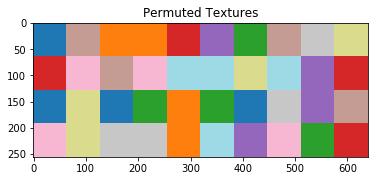

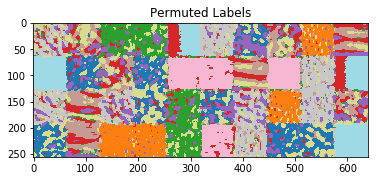

In [8]:
# Plot of predicted label map
plt.imshow(perm_label_map, cmap = "tab20")
plt.title("Permuted Textures")
plt.figure()
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

In [9]:
# Confusion matrix
# we have per default 10 clusters --> should be a 10 x 10 confusion matrix

# count how many times there is cluster with predicted label
def change_lab(label, prediction):
    p_width = label.shape[0]
    p_height = label.shape[1]
    
    label = label.flatten()
    prediction = prediction.flatten()
    
    space = np.zeros((len(np.unique(label)), len(np.unique(prediction))))
    for l in range(len(np.unique(label))):
        for p in range(len(np.unique(prediction))):
        
            l_pid = np.argwhere(label == l)
            p_pid = np.argwhere(prediction == p)
        
            count = int(np.sum(np.isin(l_pid, p_pid)))
            
            space[l, p] = count
            
    cm = l_s_a(-space)
    
    change = np.zeros_like(prediction)
    for i in range(len(cm[0])):
        change[np.argwhere(prediction == cm[1][i])] = cm[0][i]
        
    return change.reshape(p_width, p_height)

pred_new_lab = change_lab(perm_label_map, predicted_perm_label_map)

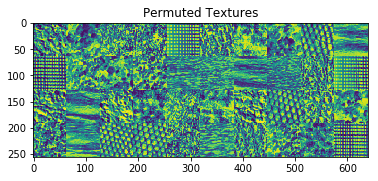

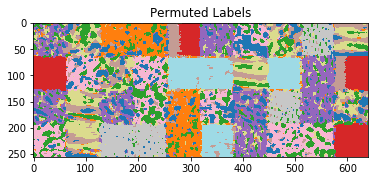

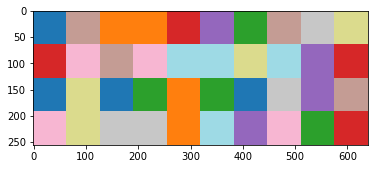

In [10]:
plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(pred_new_lab, cmap="tab20")
plt.title("Permuted Labels")
plt.figure()
plt.imshow(perm_label_map, cmap = "tab20")
plt.show()

Now one can see, that the predicted labels are assigned with the most likely cluster label as in the default. This was missing in the above part.

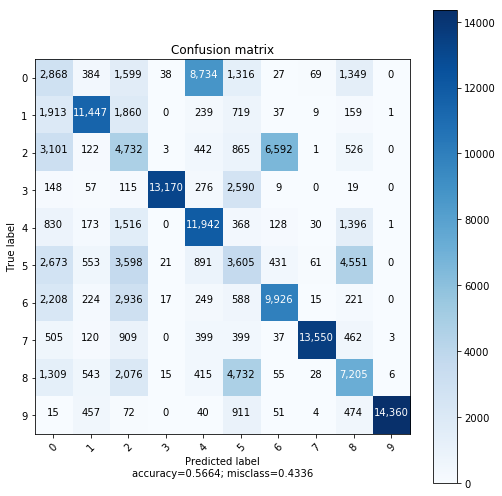

In [11]:
# The confusion matrix
conf_mat = confusion_matrix(perm_label_map.flatten(), pred_new_lab.flatten())

# The function for the confusion matrix plot is taken form: Some small changes done by myself.
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
# Very nice implementation!

def plot_confusion_matrix(cm, target_names, width = 16, height = 16,  title='Confusion matrix', cmap=None, normalize=False, ax = None):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(width, height))
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    # https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    # https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    # https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

plot_confusion_matrix(conf_mat, target_names=range(len(np.unique(perm_label_map))), width=7, height=7)

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [12]:
# 3x3 Matrix with accuracy scores of the different parameter combination
n_binis = [16, 32, 64]
w_sizes = [7, 9, 11]

space_for_plots = []
space_for_plots_tex = []
accuracy = np.zeros((len(n_binis), len(w_sizes)))
accuracy_tex = np.zeros((len(n_binis), len(w_sizes)))

for b in n_binis:
    for w in w_sizes:
        
        # predicting: 
        HC = HistogramClustering(n_clusters = 10, n_bins = b, window_size = w)
        HC.fit(texture)
        c_x = HC.predict(perm_texture)
        c_x_tex = HC.predict(texture)
        
        # changing labels
        c_x_new = change_lab(perm_label_map, c_x)
        c_x_tex_new = change_lab(label_map, c_x_tex)
        
        # save results for plots:
        lab = str("Predicted Labels - Bins: {} - WS: {}".format(b,w)) # does not work
        
        # accuracy:
        conf_mat = confusion_matrix(perm_label_map.flatten(), c_x_new.flatten())
        conf_mat_tex = confusion_matrix(label_map.flatten(), c_x_tex_new.flatten())
        
        acc = np.trace(conf_mat)/np.sum(conf_mat)
        acc_tex = np.trace(conf_mat_tex)/np.sum(conf_mat_tex)
        
        save_rs = {"labs": lab, "data": c_x_new, "Accur": acc}
        save_rs_tex = {"labs": lab, "data": c_x_tex_new, "Accur": acc_tex}
        
        space_for_plots.append(save_rs) 
        space_for_plots_tex.append(save_rs_tex)
        
        # get row index 
        r=np.argwhere(b == np.array(n_binis))
        c=np.argwhere(w == np.array(w_sizes))

        accuracy[r,c] = acc
        accuracy_tex[r,c] = acc_tex

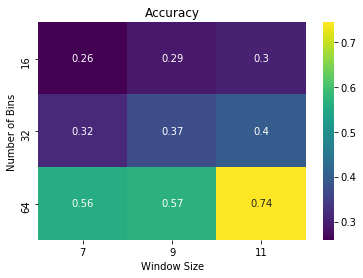

In [13]:
# plotting 
accuracy = pd.DataFrame(accuracy)
accuracy.columns = w_sizes
accuracy.index = n_binis
sn.heatmap(accuracy, annot=True, cmap = "viridis")
plt.title("Accuracy")
plt.ylabel("Number of Bins")
plt.xlabel("Window Size")
plt.show()

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

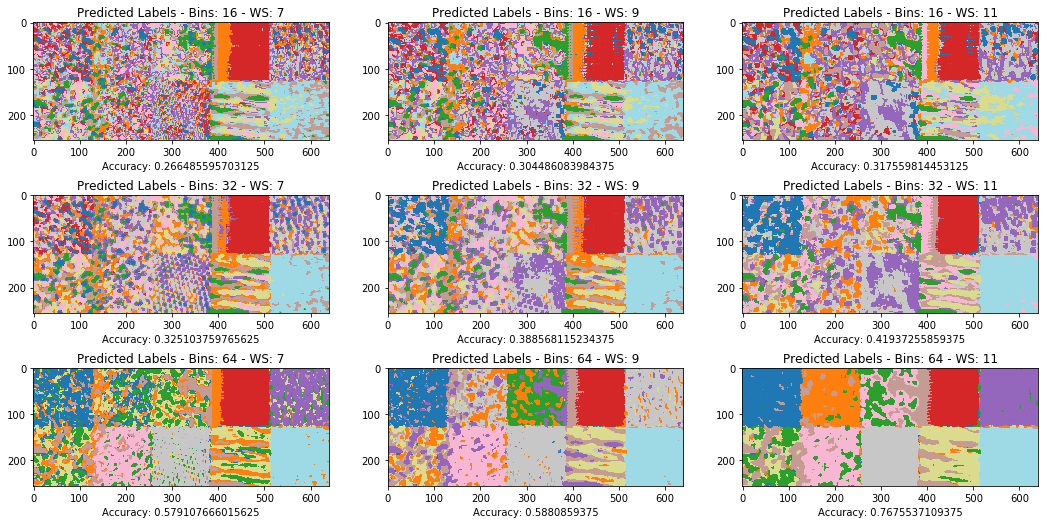

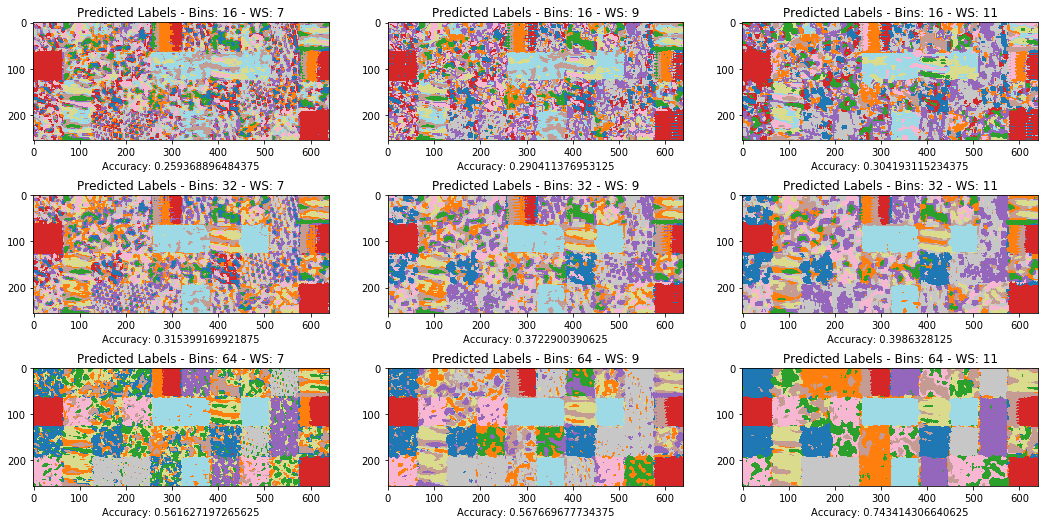

In [14]:

# Cluster predictions (9 plots arranged in a 3x3 grid)
# Texture
fig, axs = plt.subplots(3,3, figsize=(18, 9))
axs = axs.ravel()
for i in range(len(space_for_plots_tex)):
    axs[i].imshow(space_for_plots_tex[i]['data'],cmap = "tab20")
    axs[i].set_title(space_for_plots_tex[i]['labs'])
    axs[i].set_xlabel("Accuracy: {}".format(space_for_plots_tex[i]['Accur']))
    

# perm_texture
fig, axs = plt.subplots(3,3, figsize=(18, 9))
axs = axs.ravel()
for i in range(len(space_for_plots)):
    axs[i].imshow(space_for_plots[i]['data'],cmap = "tab20")
    axs[i].set_title(space_for_plots[i]['labs'])
    axs[i].set_xlabel("Accuracy: {}".format(space_for_plots[i]['Accur']))

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

In [15]:
# hungarian method in order to map the pathes with clusters
pred_labels_match = HC.predict(texture)
label = label_map.flatten()
prediction = pred_labels_match.flatten()
space = np.zeros((len(np.unique(label)), len(np.unique(prediction))))

for l in range(len(np.unique(label))):
    for p in range(len(np.unique(prediction))):
        l_pid = np.argwhere(label == l)
        p_pid = np.argwhere(prediction == p)
        count = int(np.sum(np.isin(l_pid, p_pid)))
        space[l, p] = count
cm = l_s_a(-space)[1]

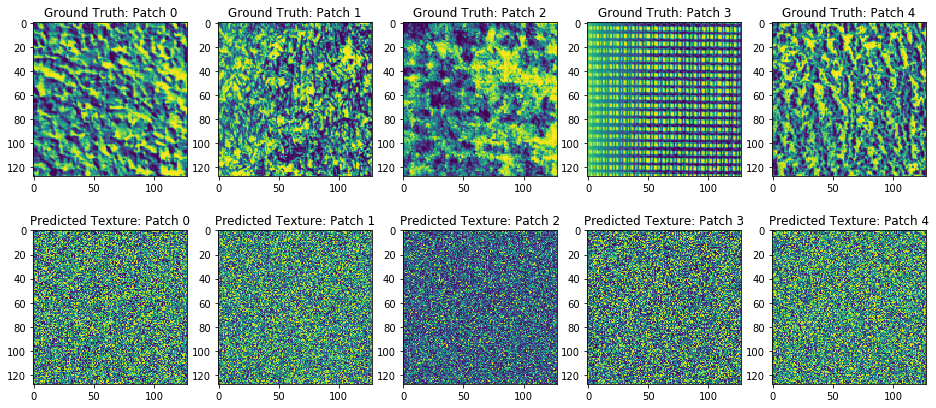

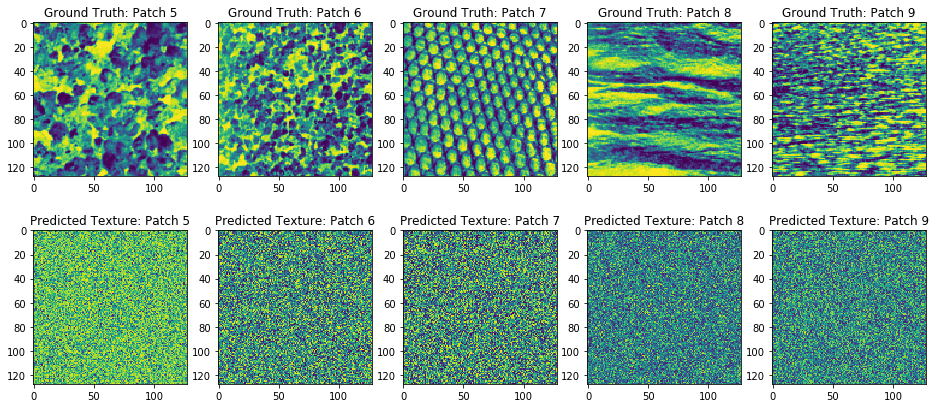

In [16]:
C1 = np.ones(patch_shape) * 0
X1 = HC.generate(C1)

true_and_pred_texture = []

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    ground_truth = texture[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)]
    C1 = np.ones(patch_shape) * cm[patch]
    X1 = HC.generate(C1)
    res_save = {'True': ground_truth, 'Fake': X1, 'Title': patch}
    true_and_pred_texture.append(res_save)

    
fig, axs = plt.subplots(2,5, figsize=(16, 7))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(true_and_pred_texture[i]['True'])
    axs[i].set_title("Ground Truth: Patch {}".format(true_and_pred_texture[i]['Title']))
    axs[i+5].imshow(true_and_pred_texture[i]['Fake'])
    axs[i+5].set_title("Predicted Texture: Patch {}".format(true_and_pred_texture[i]['Title']))
    
fig, axs = plt.subplots(2,5, figsize=(16, 7))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(true_and_pred_texture[i+5]['True'])
    axs[i].set_title("Ground Truth: Patch {}".format(true_and_pred_texture[i+5]['Title']))
    axs[i+5].imshow(true_and_pred_texture[i+5]['Fake'])
    axs[i+5].set_title("Predicted Texture: Patch {}".format(true_and_pred_texture[i+5]['Title']))
                    

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

Fitting K-means and the MAP reveals quite similar performance between them. Both K-means and also HC-MAP do not perform quite well. Beside their similar performance, it both are not able to classify all the pixels correctly to their right centroid. However if one increases the default values one can see that both, k-means and HC-MAP perform very nice! and are able to classify the texutre and permuted texture in a reasonable good manner. On the other side, both need a predefined number of clusters. DA would allow to specify an arbitrarly large amount of clusters. The clusters itself would then split as much as needed for the current Temperature.

In [17]:
# fitting K_Means clustering
# ---------------------------------------------------------------------------------------------
# extract the features used afterwards for the kmeans algorithm
HC_prep_KM = HistogramClustering()
HC_prep_KM.fit(texture)
features_km = HC_prep_KM.hist

# fit kmeans
KM = KMeans(n_clusters = 10, random_state = 7) # always set random state to lucky number ;P
KM.fit(features_km)
km_labels = KM.labels_ # predicted labels for the fitted data set. 

# in order to be able to predict one needs to consturct the histograms of the perm_texture
HC_prep_KM_predict = HistogramClustering()
HC_prep_KM_predict.fit(perm_texture)
feature_predict_km = HC_prep_KM_predict.hist
km_pred_perm = KM.predict(feature_predict_km)

# in order to compare: need to predict the perm_texture with the MAP:
MAP_pred = HC_prep_KM.predict(perm_texture)

Text(0.5, 1.0, 'MAP: Predicted-Labeling: Nr. Bins: 64, Window: 7')

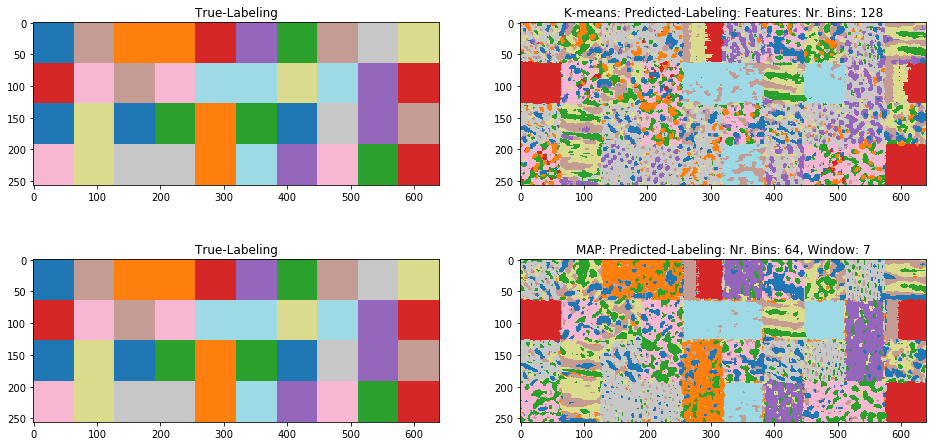

In [18]:
km_lab_new_1 = change_lab(perm_label_map, km_pred_perm.reshape(perm_label_map.shape))
MAP_lab_new_1 = change_lab(perm_label_map, MAP_pred.reshape(perm_label_map.shape))

fig, axs = plt.subplots(2, 2, figsize = (16, 8))
axs = axs.ravel()

axs[1].imshow(km_lab_new_1, cmap = "tab20")
axs[1].set_title("K-means: Predicted-Labeling: Features: Nr. Bins: 128")
axs[0].imshow(perm_label_map, cmap = "tab20")
axs[0].set_title("True-Labeling")
axs[2].imshow(perm_label_map, cmap = "tab20")
axs[2].set_title("True-Labeling")
axs[3].imshow(MAP_lab_new_1, cmap = "tab20")
axs[3].set_title("MAP: Predicted-Labeling: Nr. Bins: 64, Window: 7")

One sees: that with the default values (n_bins = 64, window_size = 7) both do not perform that well...
However: if one increases it to almost the double one sees:

In [19]:
# fitting K_Means clustering
# ---------------------------------------------------------------------------------------------
# extract the features used afterwards for the kmeans algorithm
HC_prep_KM = HistogramClustering(n_bins = 128, window_size = 15)
HC_prep_KM.fit(texture)
features_km = HC_prep_KM.hist

# fit kmeans
KM_1 = KMeans(n_clusters = 10, random_state = 7) # always set random state to lucky number ;P
KM_1.fit(features_km)
km_labels = KM.labels_ # predicted labels for the fitted data set. 

# in order to be able to predict one needs to consturct the histograms of the perm_texture
HC_prep_KM_predict = HistogramClustering(n_bins = 128, window_size = 15)
HC_prep_KM_predict.fit(perm_texture)
feature_predict_km = HC_prep_KM_predict.hist
km_pred_perm = KM_1.predict(feature_predict_km)

# in order to compare: need to predict the perm_texture with the MAP:
MAP_pred = HC_prep_KM_predict.predict(perm_texture)

Text(0.5, 1.0, 'MAP: Predicted-Labeling: Nr. Bins: 128, Window: 15')

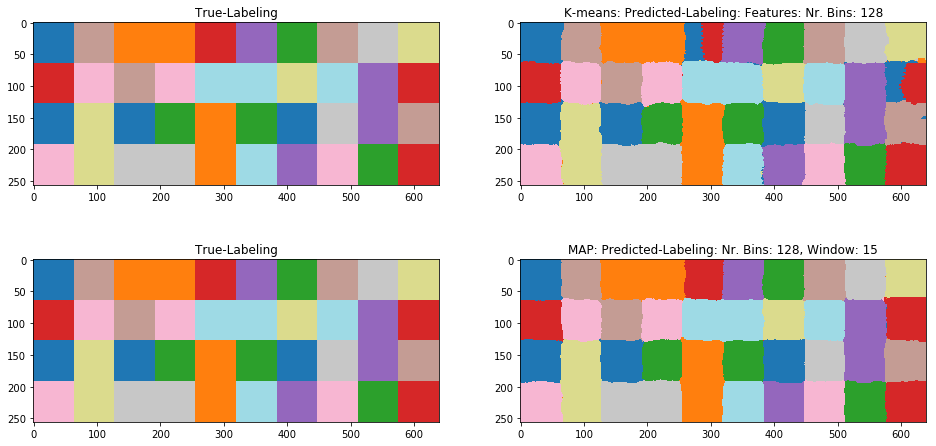

In [20]:
km_lab_new = change_lab(perm_label_map, km_pred_perm.reshape(perm_label_map.shape))
MAP_lab_new = change_lab(perm_label_map, MAP_pred.reshape(perm_label_map.shape))

fig, axs = plt.subplots(2, 2, figsize = (16, 8))
axs = axs.ravel()

axs[1].imshow(km_lab_new, cmap = "tab20")
axs[1].set_title("K-means: Predicted-Labeling: Features: Nr. Bins: 128")
axs[0].imshow(perm_label_map, cmap = "tab20")
axs[0].set_title("True-Labeling")
axs[2].imshow(perm_label_map, cmap = "tab20")
axs[2].set_title("True-Labeling")
axs[3].imshow(MAP_lab_new, cmap = "tab20")
axs[3].set_title("MAP: Predicted-Labeling: Nr. Bins: 128, Window: 15")

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

In order to compare to the above, I do plot four confusion matrices. Two for k-means and two for HC-MAP. 
Using once only window size 7 and number of bins 64. And once using number of bins 128 and windowsize 15.
One sees how both perform very similar. 

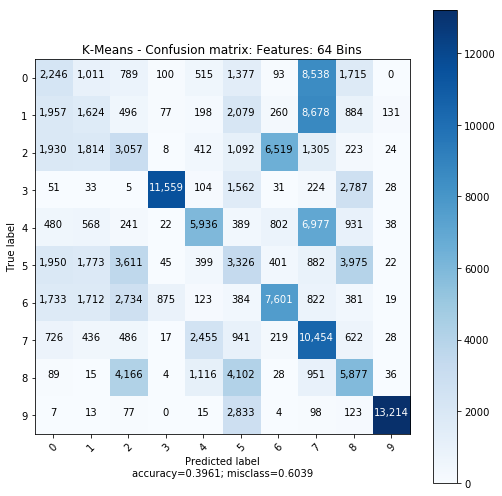

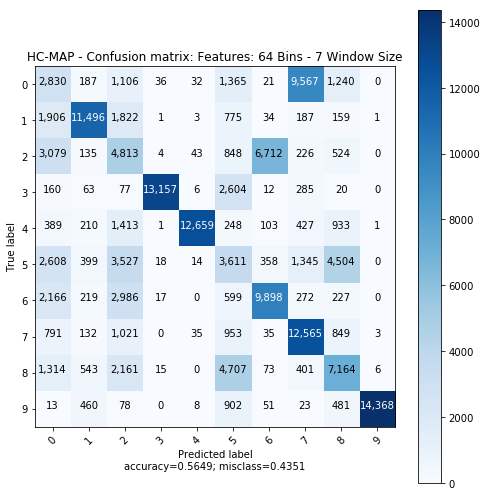

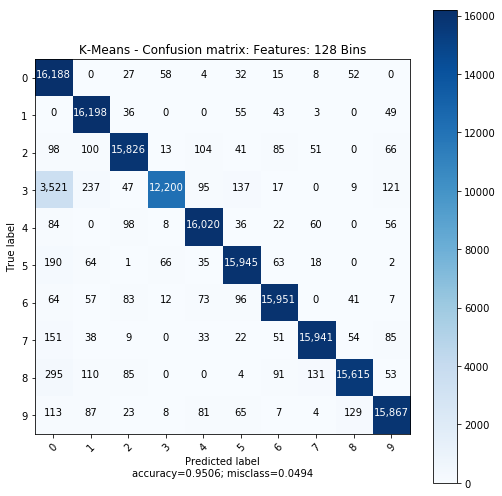

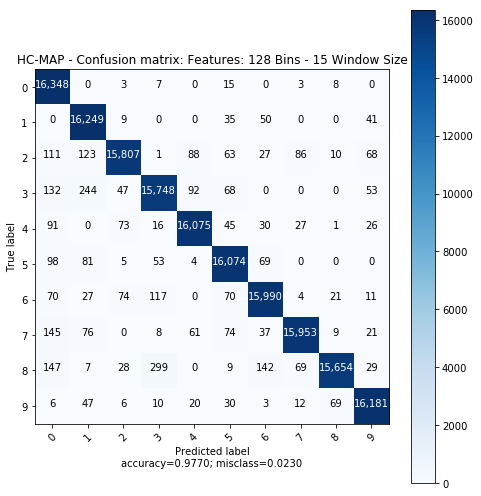

In [21]:
# Confusion matrices
# -----------------------------------------------------------------------------------------------------------
# K-Means: Features: 64 Bins - Window Size 7: used to prepare Feature Vectors
conf_mat_km_1 = confusion_matrix(perm_label_map.flatten(), km_lab_new_1.flatten())
plot_confusion_matrix(conf_mat_km_1,target_names=range(len(np.unique(perm_label_map))), 
                      width=7, height=7, title='K-Means - Confusion matrix: Features: 64 Bins')

# HC-MAP: 64 Bins - Window Size 7
conf_mat_HCMAP_1 = confusion_matrix(perm_label_map.flatten(), MAP_lab_new_1.flatten())
plot_confusion_matrix(conf_mat_HCMAP_1,target_names=range(len(np.unique(perm_label_map))), 
                      width=7, height=7, title='HC-MAP - Confusion matrix: Features: 64 Bins - 7 Window Size')

# K-Means: Features: 128 Bins - Window Size 15: used to prepare Feature Vectors
conf_mat_km = confusion_matrix(perm_label_map.flatten(), km_lab_new.flatten())
plot_confusion_matrix(conf_mat_km,target_names=range(len(np.unique(perm_label_map))), 
                      width=7, height=7, title='K-Means - Confusion matrix: Features: 128 Bins')

# HC-MAP: 128 Bins - Window Size 15
conf_mat_HCMAP = confusion_matrix(perm_label_map.flatten(), MAP_lab_new.flatten())
plot_confusion_matrix(conf_mat_HCMAP,target_names=range(len(np.unique(perm_label_map))),
                      width=7, height=7, title='HC-MAP - Confusion matrix: Features: 128 Bins - 15 Window Size')

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [22]:
# map the clusters of k-means with the patches (once again):
# hungarian method in order to map the patches with clusters
# km_labels are already the labels for the km-means with default values.
label = label_map.flatten()
prediction = km_labels.flatten()
space = np.zeros((len(np.unique(label)), len(np.unique(prediction))))

for l in range(len(np.unique(label))):
    for p in range(len(np.unique(prediction))):
        l_pid = np.argwhere(label == l)
        p_pid = np.argwhere(prediction == p)
        count = int(np.sum(np.isin(l_pid, p_pid)))
        space[l, p] = count
cm_km = l_s_a(-space)[1]

In [23]:
# Histograms
# HC is the one fitted class with the default values. 
# ---------------------------------------------------------------------------------------------

# create nice dictionaries with data inside:
collection = []
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    ground_truth = texture[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)]
    
    # generate the data to plot...
    c_mapped = cm[patch]
    c_km_mapped = cm_km[patch]
    km_center = KM.cluster_centers_
    # histogram of the patch
    patch_hist = np.histogram(ground_truth, bins = HC.n_bins, range = (0,1))[0]
    patch_hist = patch_hist/np.sum(patch_hist)
    
    c_data = HC.centroids[c_mapped,:]
    collection.append({'Patch_id': patch, 
                  'P_hist': patch_hist, 
                  'P_centroid': c_mapped, 
                  'HC_data': c_data, 
                  'KM_id': c_km_mapped, 
                  'KM_centroid':km_center[c_km_mapped,:]})

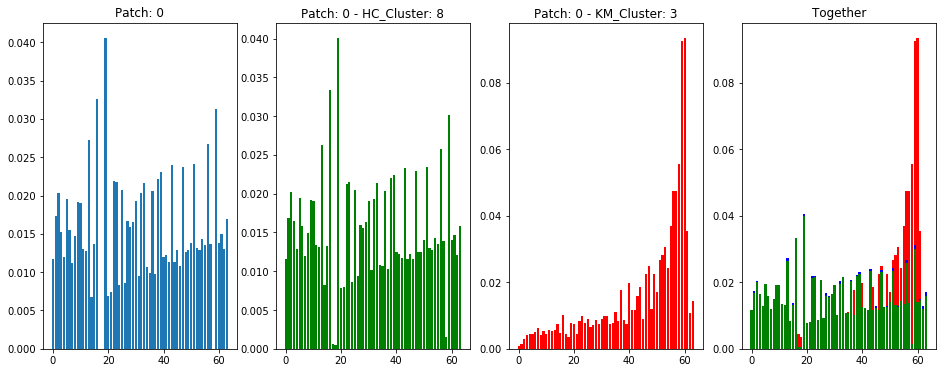

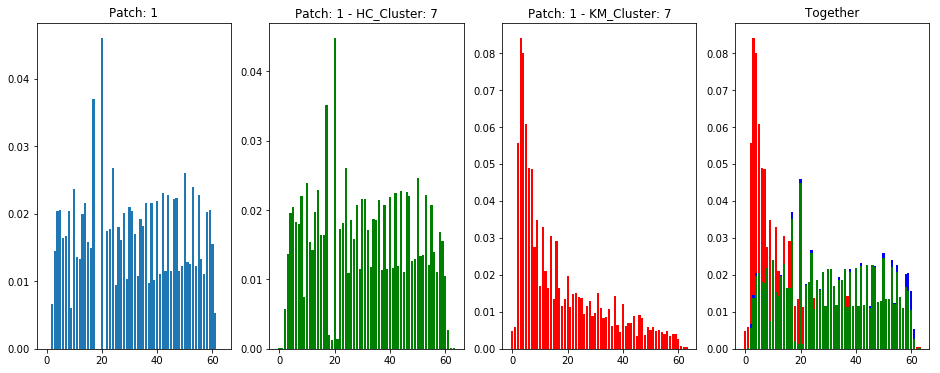

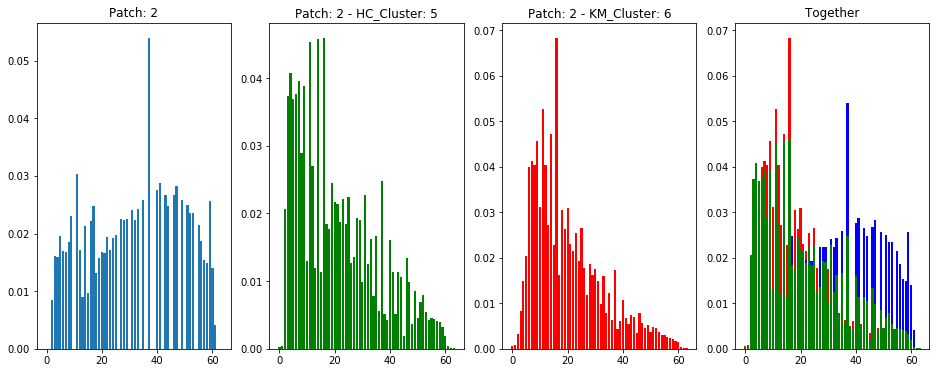

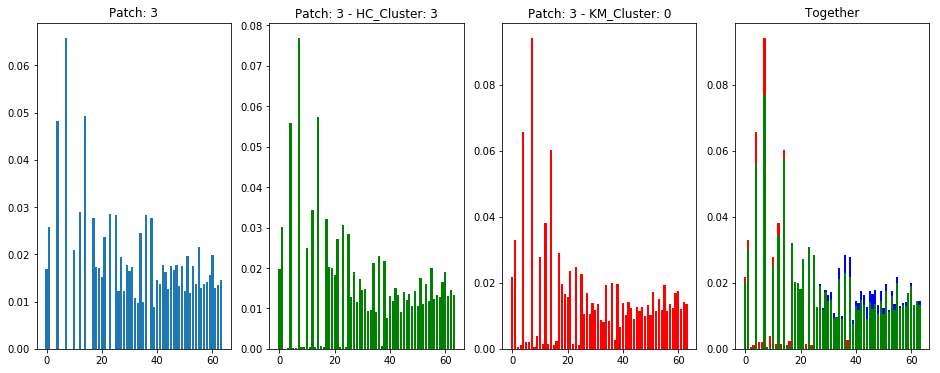

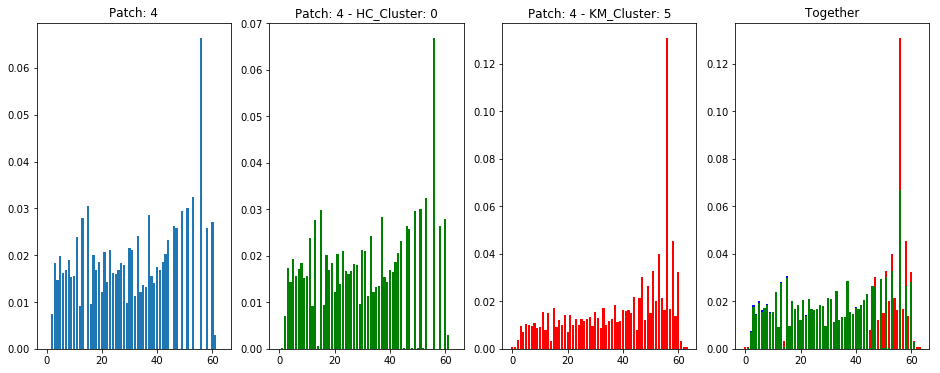

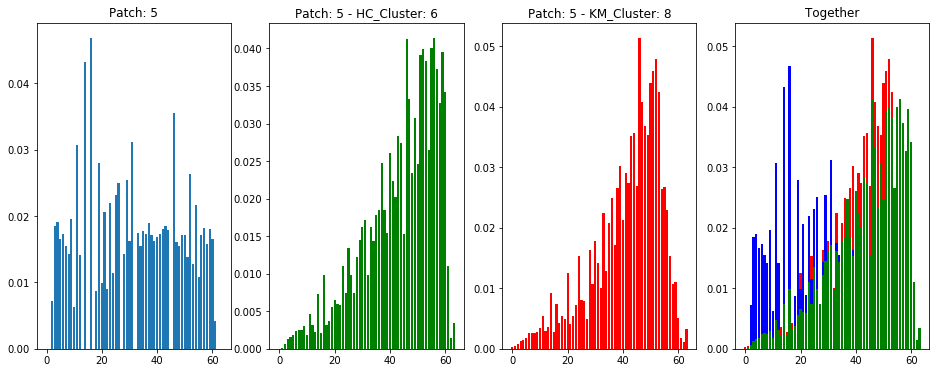

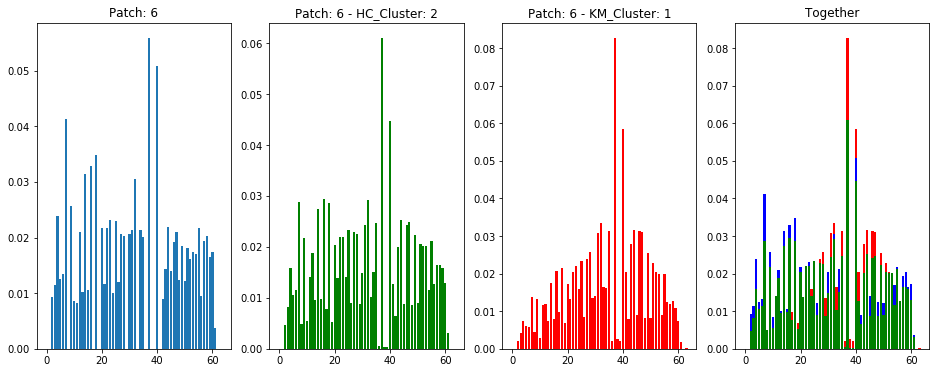

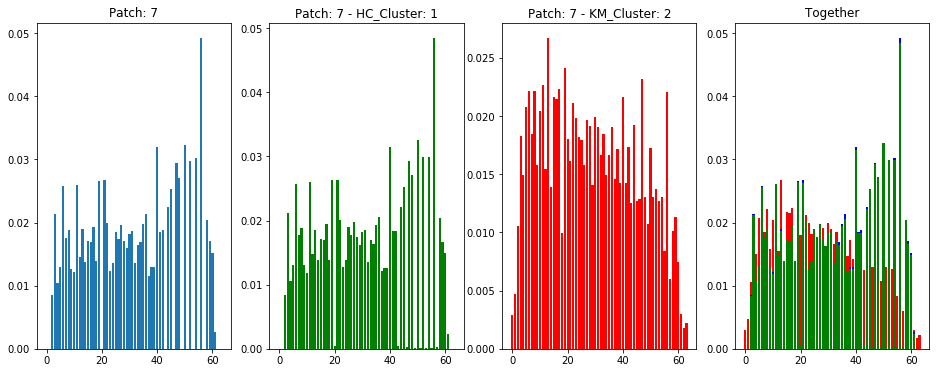

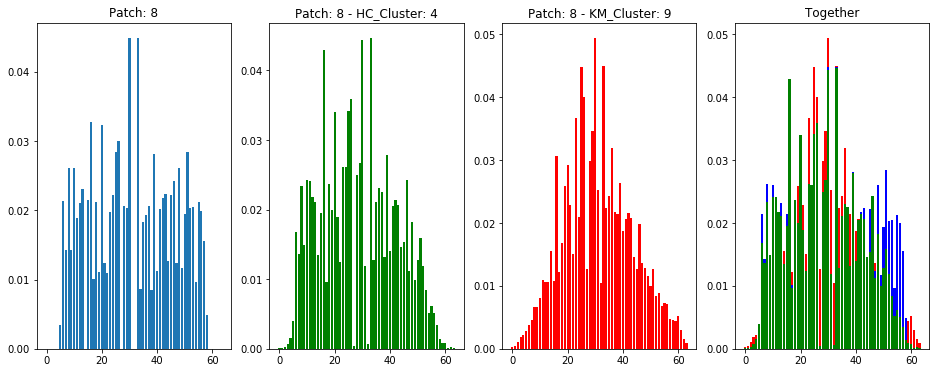

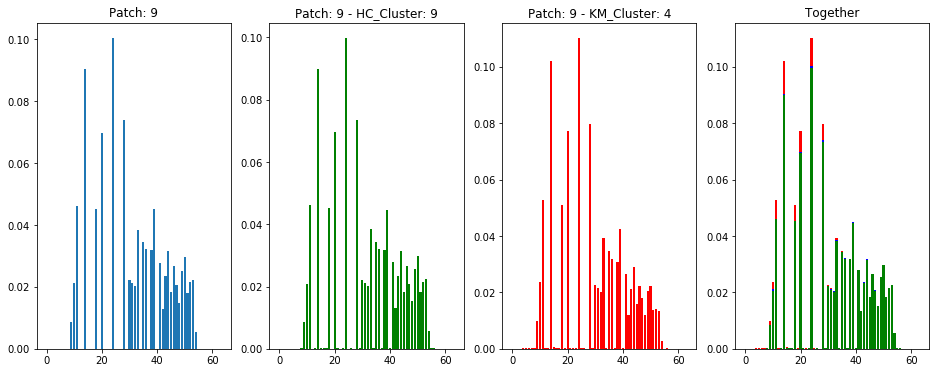

In [24]:
# plotting the histograms 
# ---------------------------------------------------------------------------------------------
for patch in range(np.prod(patch_grid_shape)):
    fig, axs = plt.subplots(1, 4, figsize = (16, 6))
    axs = axs.ravel()
    bin_id = np.arange(0, HC.n_bins)
    axs[0].bar(bin_id, collection[patch]['P_hist'])
    axs[0].set_title("Patch: {}".format(collection[patch]['Patch_id']))
    axs[1].bar(bin_id, collection[patch]['HC_data'], color = "green")
    axs[1].set_title("Patch: {} - HC_Cluster: {}".format(collection[patch]['Patch_id'],
                                                         collection[patch]['P_centroid']))
    axs[2].bar(bin_id, collection[patch]['KM_centroid'], color = "red")
    axs[2].set_title("Patch: {} - KM_Cluster: {}".format(collection[patch]['Patch_id'],
                                                         collection[patch]['KM_id']))
    axs[3].bar(bin_id, collection[patch]['KM_centroid'], color = "red")
    axs[3].bar(bin_id, collection[patch]['P_hist'], color = "blue")
    axs[3].bar(bin_id, collection[patch]['HC_data'], color = "green")
    axs[3].set_title("Together")

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

I do again compare the DA algorithm with the default values and the doubled default values. It is realy nice to see, how DA works for HC. It is quite amazing, had really fun implementing it. The algorithm using doubled Defaults is much faster then the one using default values. As expected due to the previous results. First I show the output with the default values. However this part would take about 40 min to 1 hour, because of my inefficient implementation and looping trough all of the individual pixels. The one with doubled defaults is quite faster.

**Default values:**

T:  0.34


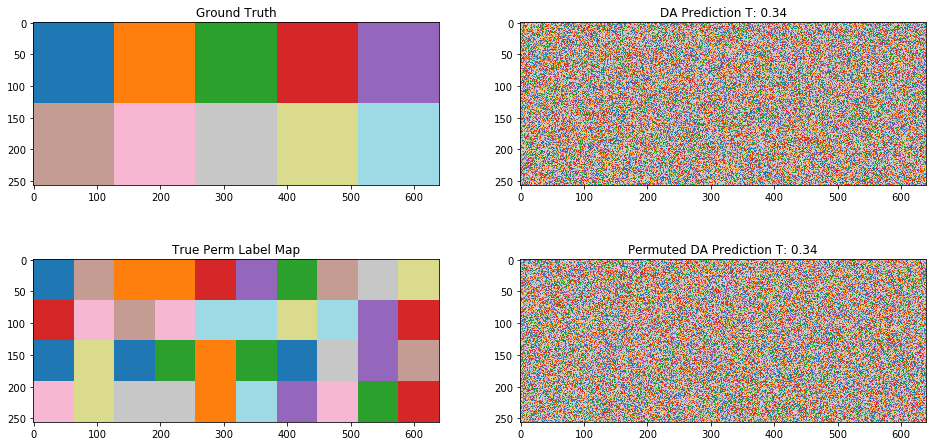

T:  0.289


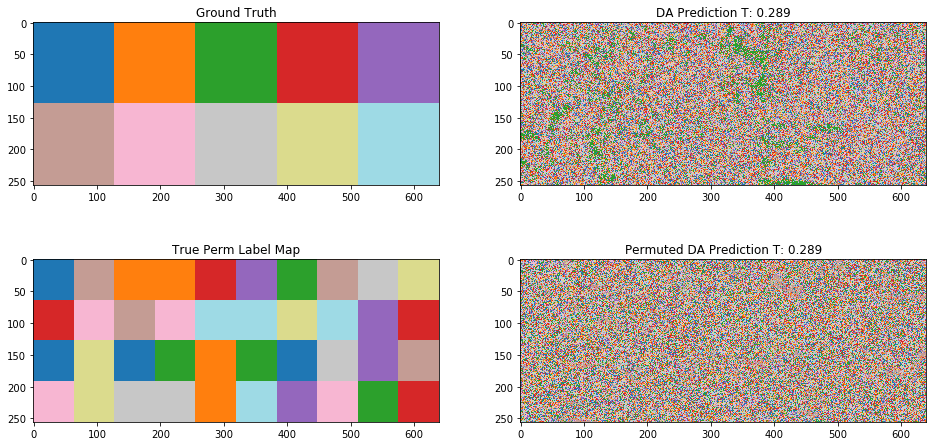

T:  0.24565


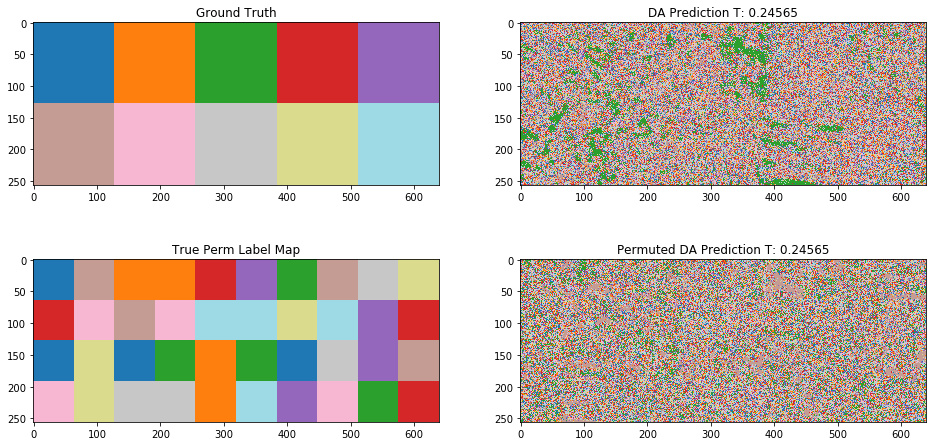

T:  0.2088


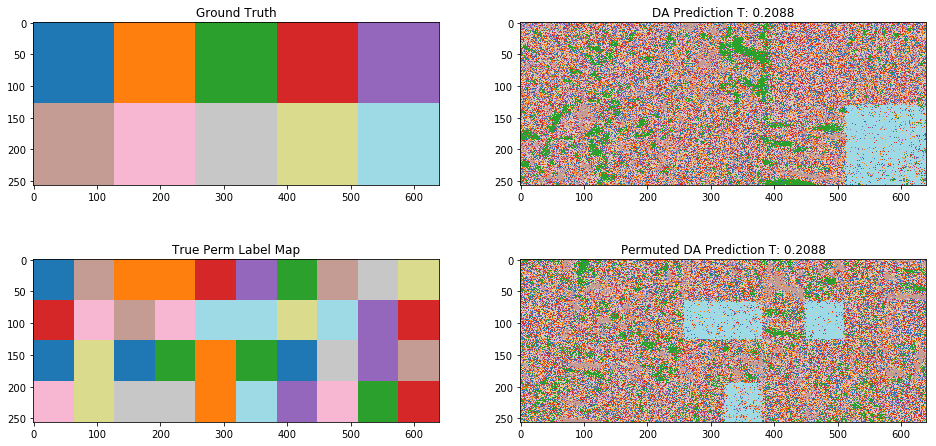

T:  0.17748


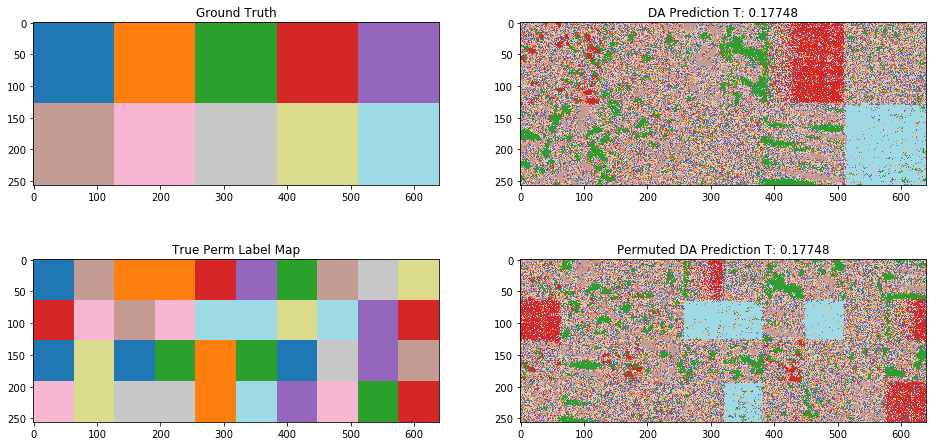

T:  0.15086


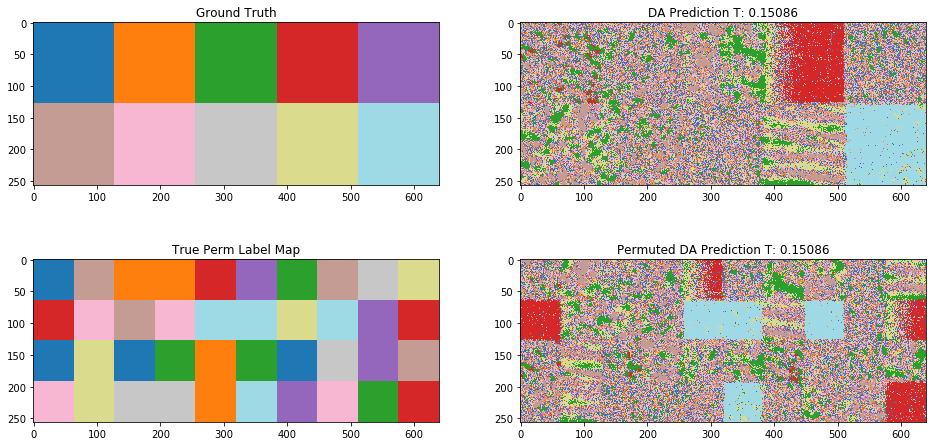

T:  0.12823


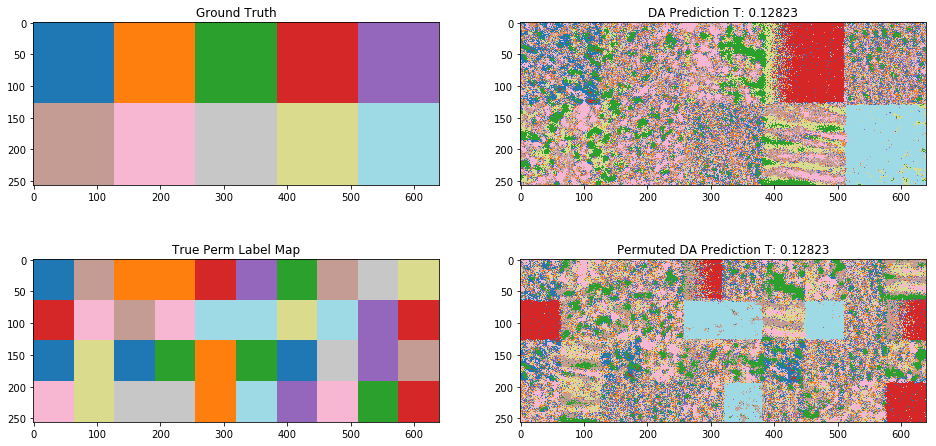

T:  0.109


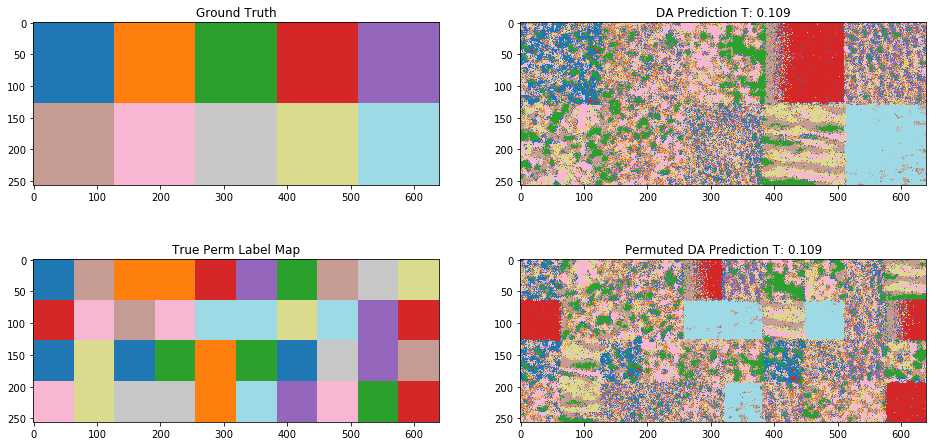

T:  0.09265


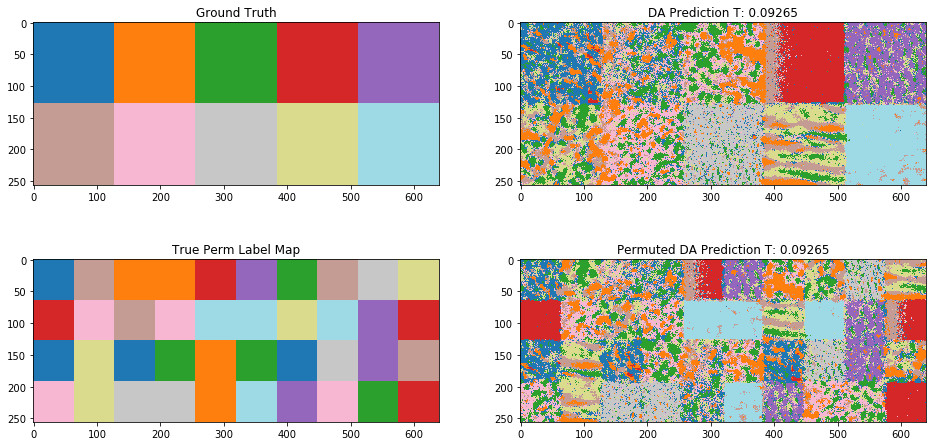

T:  0.07875


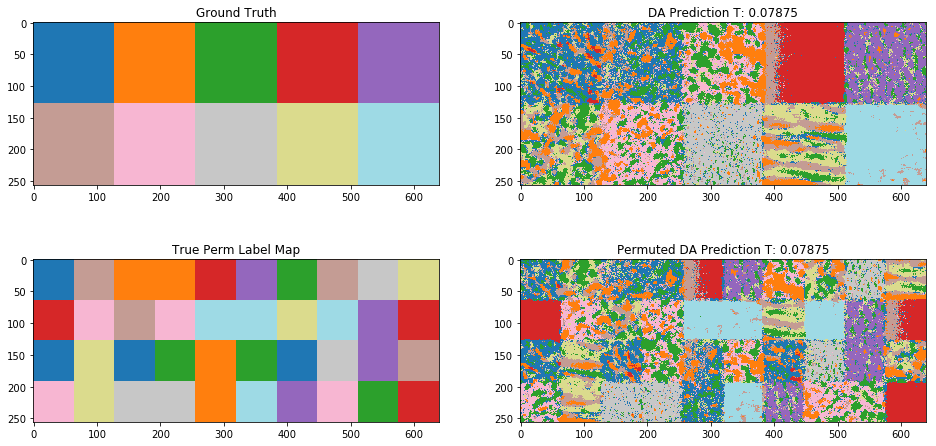

T:  0.06694


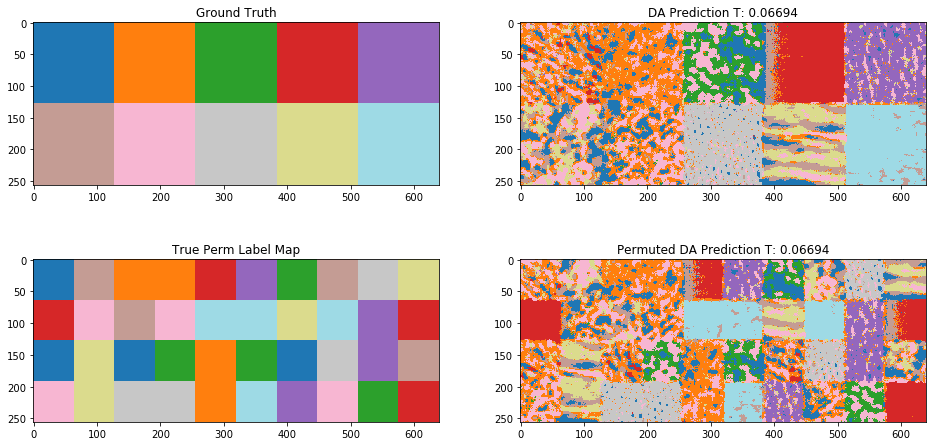

T:  0.0569


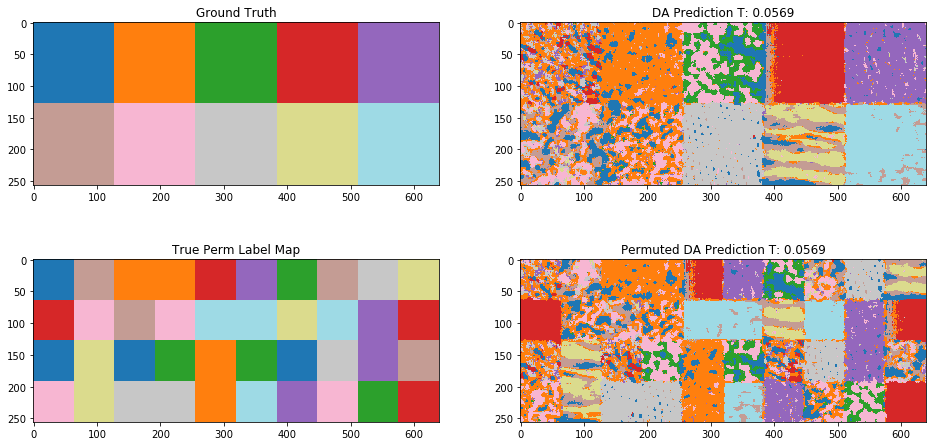

T:  0.04836


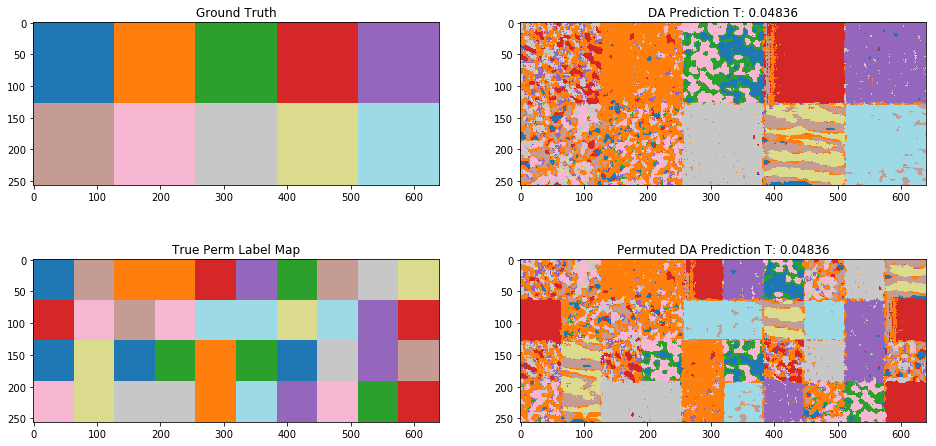

T:  0.04111


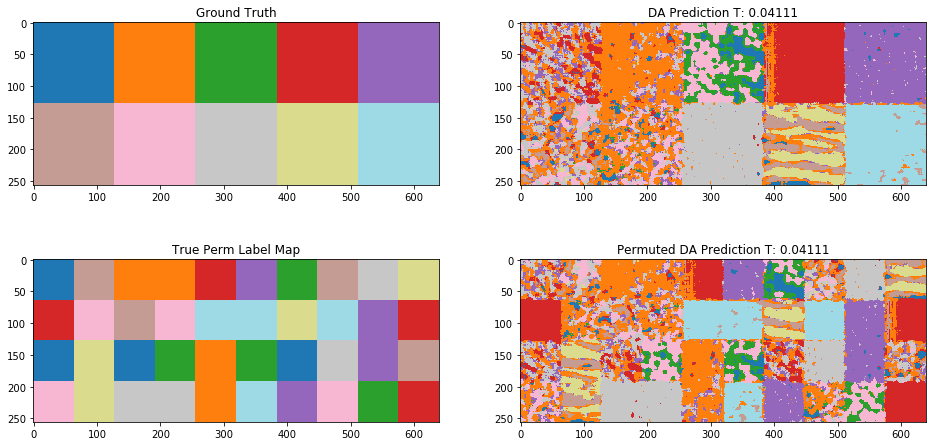

T:  0.03494


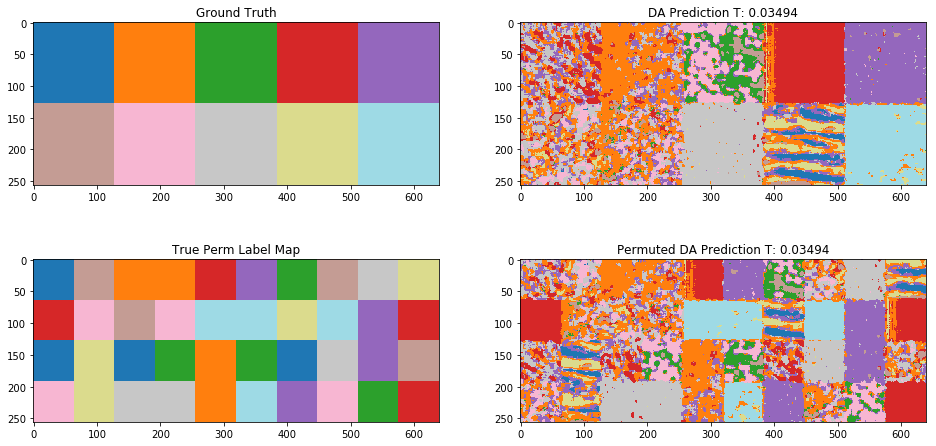

CPU times: user 32min 6s, sys: 4min 19s, total: 36min 25s
Wall time: 35min


In [25]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

**Doubled default values:**

T:  0.34


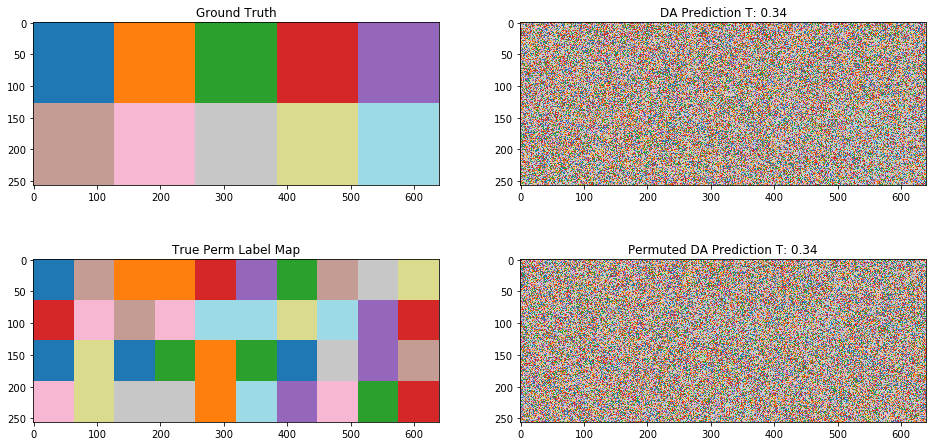

T:  0.289


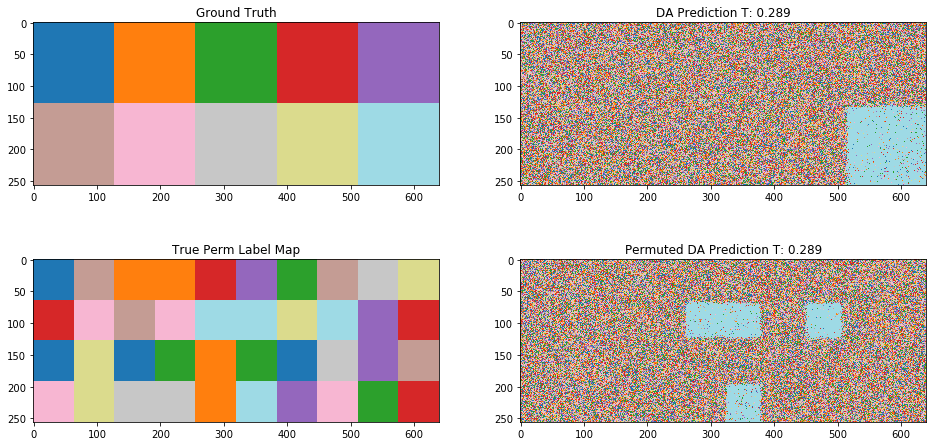

T:  0.24565


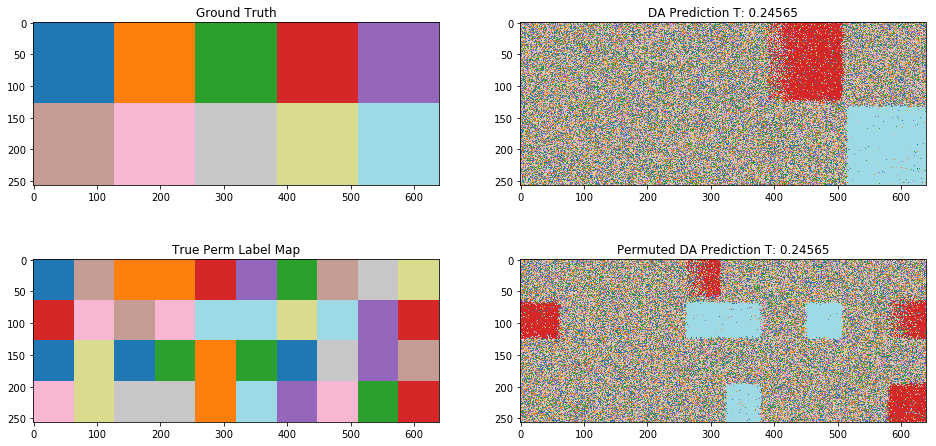

T:  0.2088


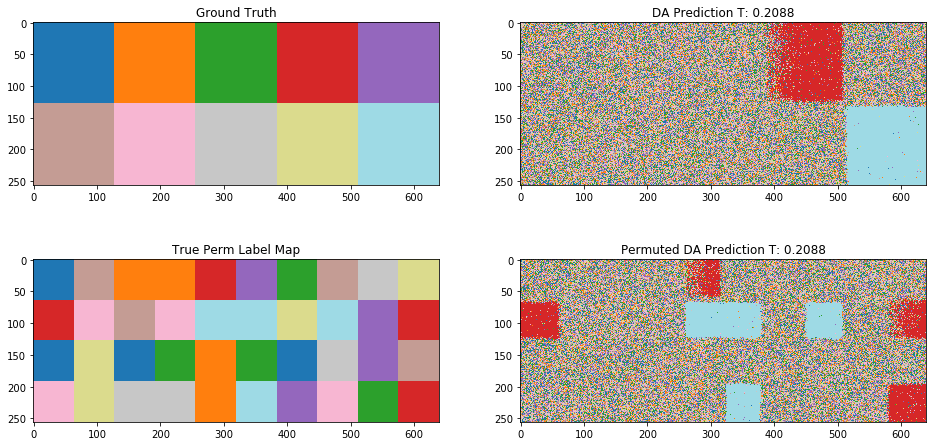

T:  0.17748


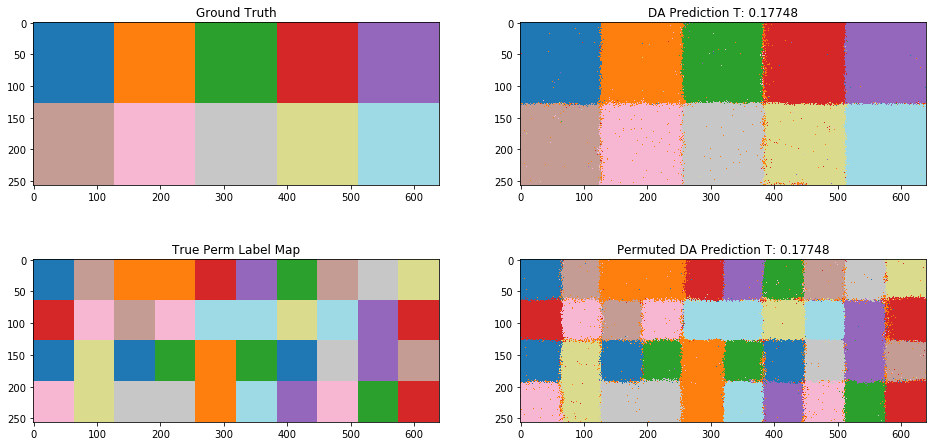

T:  0.15086


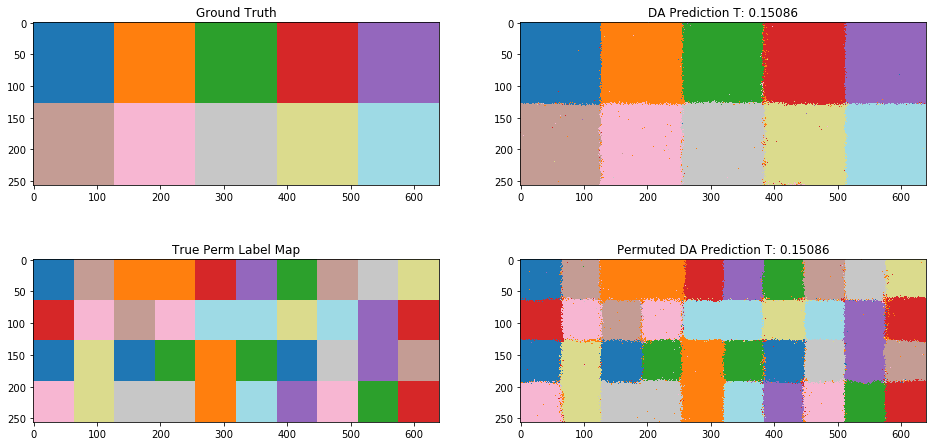

T:  0.12823


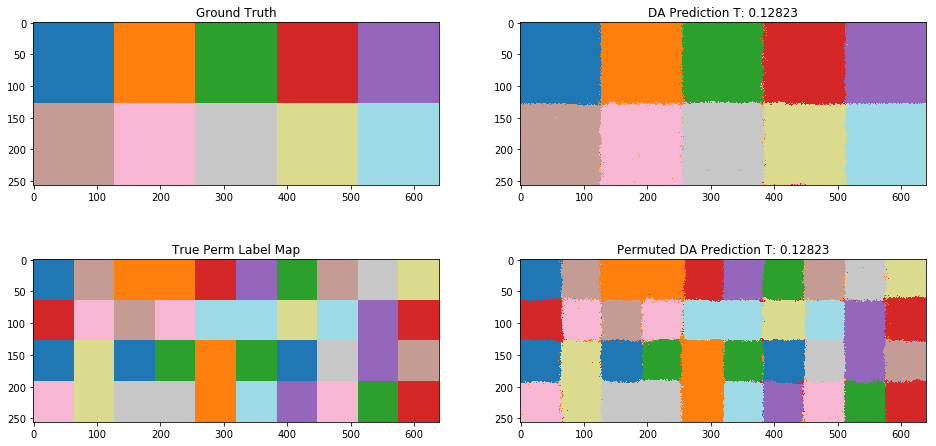

T:  0.109


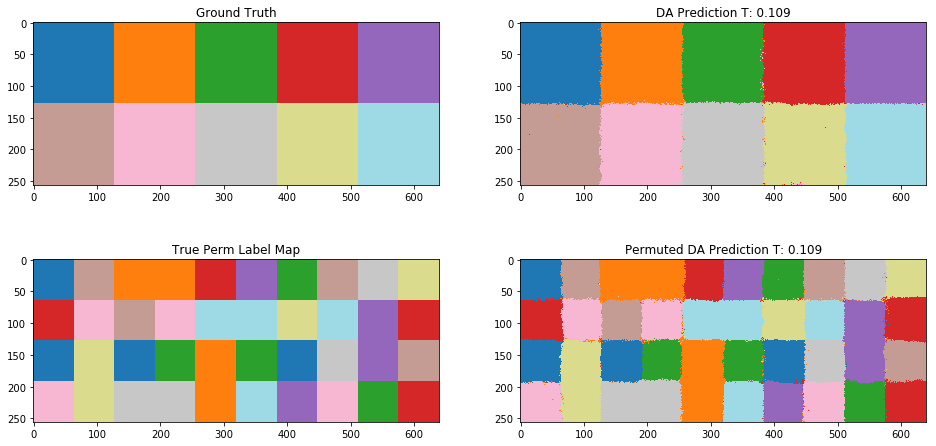

T:  0.09265


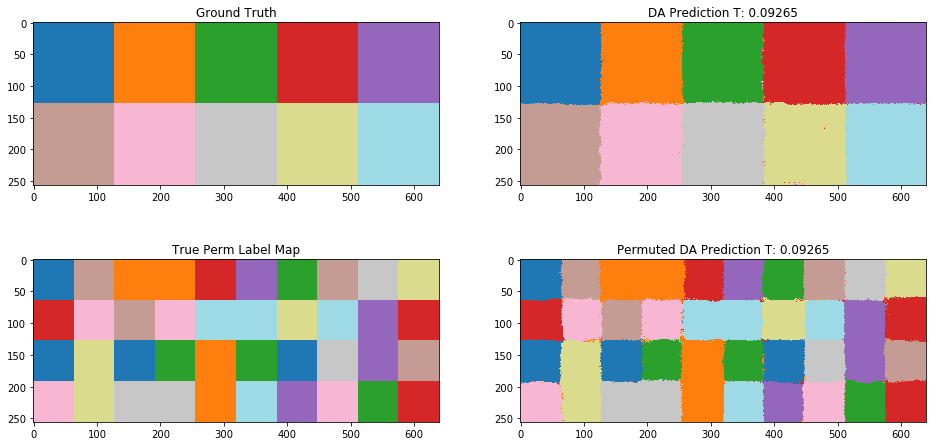

T:  0.07875


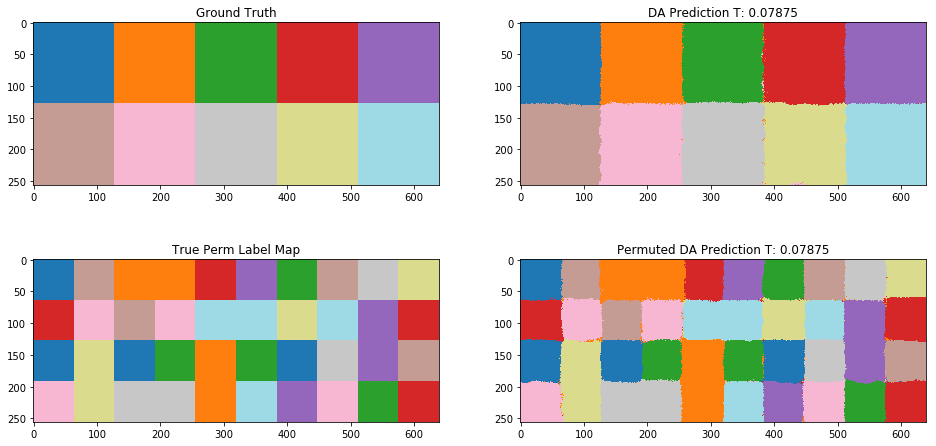

T:  0.06694


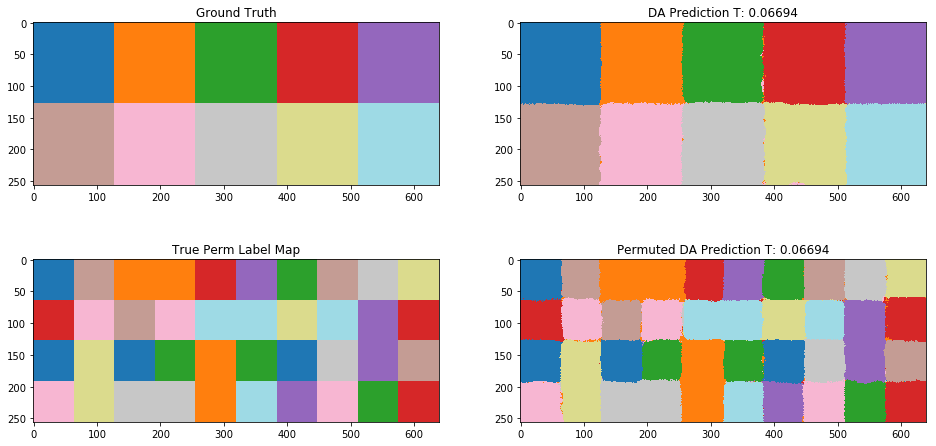

T:  0.0569


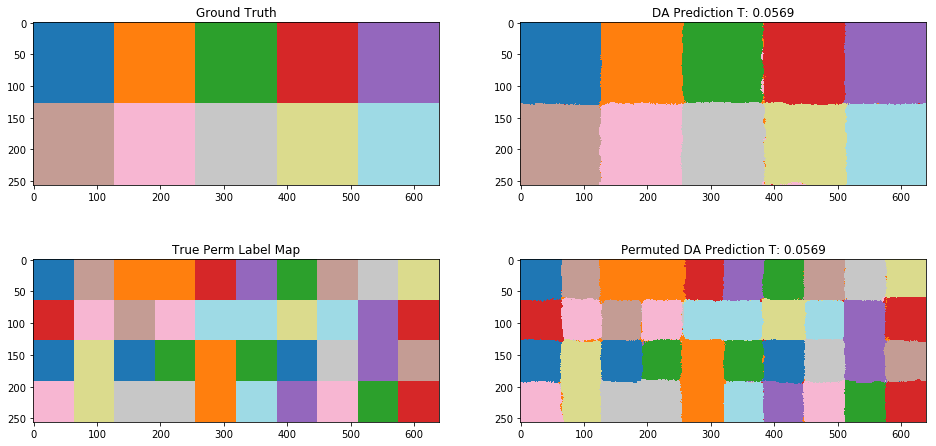

T:  0.04836


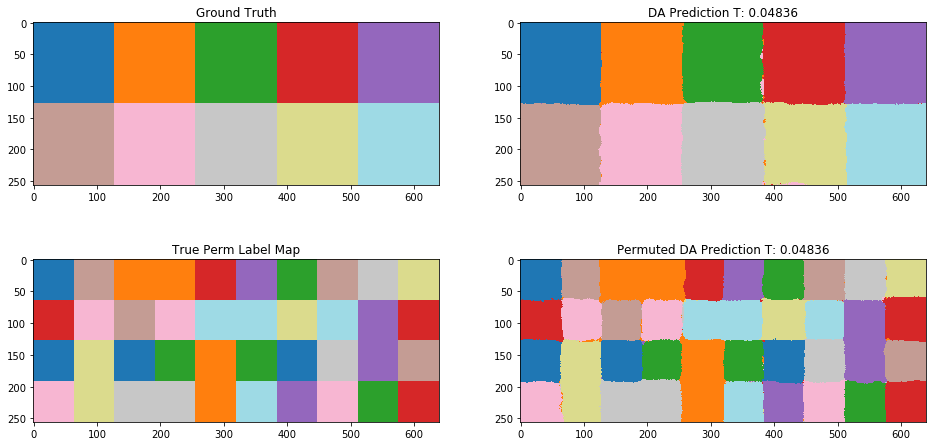

T:  0.04111


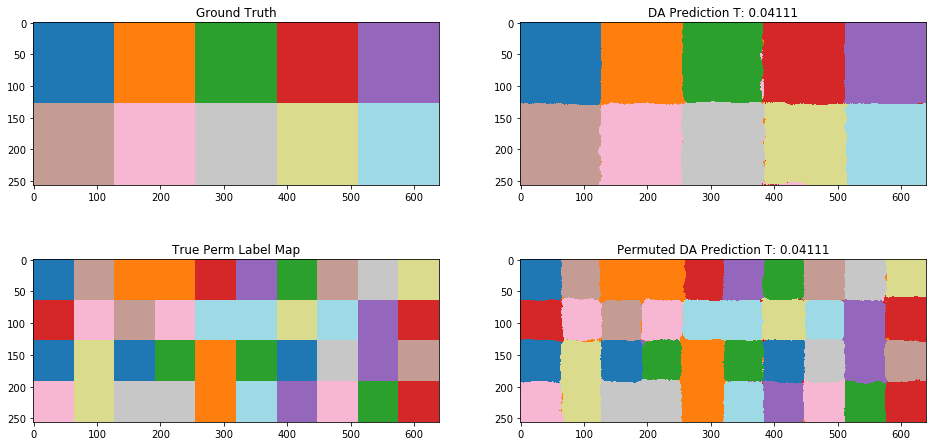

T:  0.03494


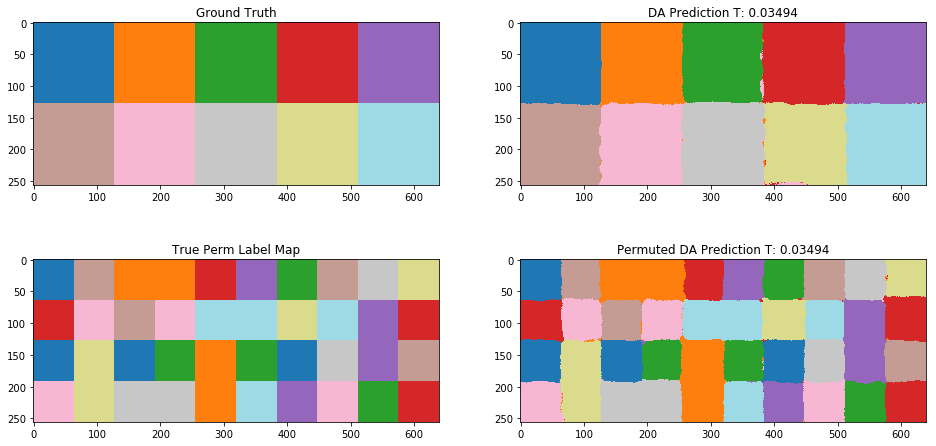

CPU times: user 18min 59s, sys: 8min 32s, total: 27min 31s
Wall time: 27min 16s


In [26]:
%%time
HC = HistogramClustering(estimation="DA", n_bins=128, window_size=15)
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

Its simply beautiful... DA with histogram clustering takes a while, but this is due to my inefficient way of coding and looping through all individual pixels!

I start with initializing 10 clusters as the mean of the histograms. Adding noise at each step, where the histograms are too close to each other. At the beginnig: it is like expected, every pixel is randomly assigned to one of the 10 clusters. But then after the Temperature falls it starts doing something. With lower and lower temperature has a beautiful predicted map, with only edges beeing fluctating, because of the complex texture of that areas.  However one sees that the DA with larger window size and more bins perform faster better. At the beginning there are no recognized clusters but with decreasing T it starts recognizing more and more. Its nice! However, I assign the individualt pixels to cluster c with the corresponding probability. Therefore we have in the beginning the random fluctation, without anything, no structure. If one would do something like argmax, at each assignment step, it should result in similar outputs. However, in the sense of probabilistic coding I use the probabilities to assign the pixel to the clusters, but also the probs, will go up and only favor clusters which minimize KL-Divergence. Again, very nice coding exercise! I enjoyed it alot!


## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.

The coding exercise was reaaaally nice! It helped me to understand HC much better. Also to understand DA better. Its really nice to see that DA in the end performed. Coding exercise is nice, because one could always see if the results are what one expects. However, I would not add only the default paramets. I would suggest to run once with the provided defaults and afterwards to use the doubled defaults. Otherwise one might think MAP does not work, as it is at the beginning and not working well with the defaults, as it is still a lot random assignments. 

Thanks! I enjoyed it a lot!